# Radon transform

The general Radon transform is expressed as
\begin{equation}
\label{eq:general}
\begin{split}
\tilde{m}(\tau,p) &= \int d(t=\phi(\tau,h,p),h) dh, \\
d(t,h) &= \int m(\tau=\tilde{\phi}(t,h,p),p) dp,
\end{split}
\end{equation}
with $\phi(\tau,h,p)$ called the kernel functions. By choosing different kernel functions, the Radon transform can be categorized into linear, parabolic, hyperbolic Radon transform. 

Linear Radon transform
\begin{equation}
\label{eq:li}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\tau+ph,h) \\
d(t,h) &= \sum_{p} m(\tau=t-ph,p) 
\end{split}
\end{equation}

Parabolic Radon transform
\begin{equation}
\label{eq:para}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\tau+ph^2,h) \\
d(t,h) &= \sum_{p} m(\tau=t-ph^2,p) 
\end{split}
\end{equation}

Hyperbolic Radon transform
\begin{equation}
\label{eq:hyp}
\begin{split}
\tilde{m}(\tau,p) &= \sum_{h} d(t=\sqrt{\tau^2+\frac{h^2}{p^2}},h), \\
d(t,h) &= \sum_{p} m(\tau=\sqrt{t^2-\frac{h^2}{p^2}},p), 
\end{split}
\end{equation}


References:

Sacchi, M. D., & Ulrych, T. J. (1995). High-resolution velocity gathers and offset space reconstruction. Geophysics, 60(4), 1169-1177.

Chen, Y., 2018. Automatic velocity analysis using high-resolution hyperbolic Radon transform. Geophysics, 83(4), pp.A53-A57.

Zhang, Q., Chen, Y., Zhang, F. and Chen, Y., 2022. Improving receiver function imaging with high-resolution Radon transform. Geophysical Journal International, 230(2), pp.1292-1304.


# 3. Hyperbolic Radon transform

In [1]:
def ricker(f,dt,tlength=None):
    # ricker: Ricker wavelet of central frequency f.
    #
    # INPUT:
    # f : central freq. in Hz (f <<1/(2dt) )
    # dt: sampling interval in sec
    # tlength : the duration of wavelet in sec
    #
    # OUTPUT: 
    # w:  the Ricker wavelet
    # tw: time axis
    #
    # Example
    #
    #   [w,tw] = ricker(10,0.004,0.2);
    #   pyplot.plot(tw,w);
    import numpy as np
    
    if tlength!=None:
        nw=np.floor(tlength/dt)+1;
    else:
        nw=2.2/f/dt;
        nw=2*np.floor(nw/2)+1;
    nc=np.floor(nw/2);
    nw=int(nw)
    w =np.zeros(nw);
    
    k=np.arange(1,nw+1,1);
    alpha = (nc-k+1)*f*dt*np.pi;
    beta=np.power(alpha,2);
    w = (1.-beta*2)*np.exp(-beta);
    tw = -(nc+1-k)*dt;
    return w,tw

In [2]:
import numpy as np

h=np.linspace(0,500,51);nh=len(h);
v=np.linspace(1300,2500,25);nv=len(v);

nt = 450;
dt=0.004;

m=np.zeros([nt,nv]);
d=np.zeros([nt,nh]);

w,tw=ricker(40,dt);

for it in range(0,nt,40):
    m[it,3] = np.random.randn(1,1);

import scipy.signal
w=np.expand_dims(w,1);
m=scipy.signal.convolve2d(m,w,'same');

par={'h':h,'v':v,'nt':nt,'dt':dt,'typ':3}




In [3]:
import pyradon as pr


In [4]:
d=pr.radonc(m,par,1);

d=d+0.0*np.random.randn(d.shape[0],d.shape[1]);

ma=pr.radonc(d,par,-1);



In [5]:
N1=10;
N2=1;
mi,misfit = pr.radon_l1c(par,d,np.zeros(ma.shape),N1,N2,0);

In [6]:
dp=pr.radonc(mi,par,1);

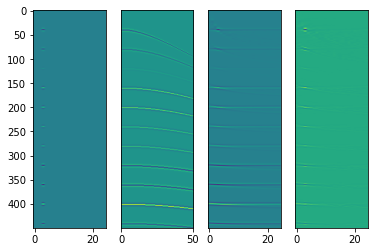

In [7]:
import matplotlib.pyplot as plt

plt.figure;
plt.subplot(1,4,1)
plt.imshow(m,aspect='auto');

plt.subplot(1,4,2)
plt.imshow(d,aspect='auto');plt.gca().set_yticks([]);

plt.subplot(1,4,3)
plt.imshow(ma,aspect='auto');plt.gca().set_yticks([]);

plt.subplot(1,4,4)
plt.imshow(mi,aspect='auto');plt.gca().set_yticks([]);


In [11]:
# dot test

m1=np.random.randn(nt,nv);
d1=pr.radonc(m1,par,1);

d2=np.random.randn(nt,nh);
m2=pr.radonc(d2,par,-1);

dot1=(d1*d2).flatten().sum();
dot2=(m1*m2).flatten().sum();

print('dot1=',dot1,'dot2=',dot2)

dot1= -180.66539640313414 dot2= -180.66551939318379


In [12]:
N1=20;
N2=3;

mi_l1,misfit_l1 = pr.radon_l1c(par,d,np.zeros(ma.shape),N1,N2,1);

dp_l1=pr.radonc(mi_l1,par,1);


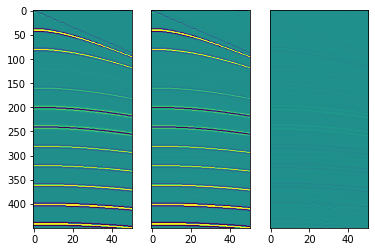

In [15]:
import matplotlib.pyplot as plt
plt.figure();

plt.subplot(1,3,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);
plt.subplot(1,3,2);
plt.imshow(dp_l1,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);
plt.subplot(1,3,3);
plt.imshow(d-dp_l1,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);


# Interpolate missing traces

In [16]:

## create indices missing trace
inds_mis1=np.linspace(10,15,5);
inds_mis2=np.linspace(26,35,10);
inds_mis=np.concatenate([inds_mis1,inds_mis2],axis=0);

d_mis=d.copy();

## create incomplete data
d_mis[:,np.int32(inds_mis)] = 0; #d_mis is for display only
d_mis_nozero=np.delete(d_mis,np.int32(inds_mis),axis=1);#delete the traces in the data

## create corresponding offset coordinates
h_mis=h;
h_mis=np.delete(h_mis,np.int32(inds_mis));



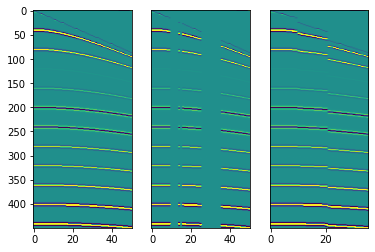

In [17]:
plt.figure();

plt.subplot(1,3,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);

plt.subplot(1,3,2);
plt.imshow(d_mis,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);

plt.subplot(1,3,3);
plt.imshow(d_mis_nozero,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);



Text(0.5, 1.0, 'Error')

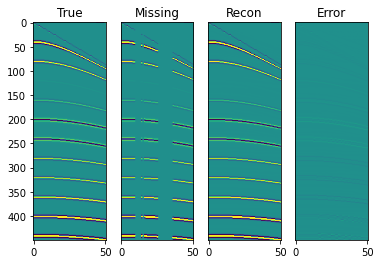

In [18]:

## change the parameter object
par['h']=h_mis; 

m_mis_l1,misfit=pr.radon_l1c(par,d_mis_nozero,np.zeros(ma.shape),N1,N2,1);

#m_mis_l1 is the inverted Radon domain from incomplete data
#for reconstruction, we need a complete offset coordinate vector
par['h']=h;
d_recon = pr.radonc(m_mis_l1,par,1);


plt.figure();

plt.subplot(1,4,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);plt.title('True')

plt.subplot(1,4,2);
plt.imshow(d_mis,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Missing')

plt.subplot(1,4,3);
plt.imshow(d_recon,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Recon')

plt.subplot(1,4,4);
plt.imshow(d-d_recon,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Error')

